In [21]:
# Import dependencies

# Python SQL toolkit and Object Relational Mapper
# engine, inspect, and functions
from sqlalchemy import create_engine, inspect, func

# Declarative base because when you want something done right... you don't use automap...
from sqlalchemy.ext.declarative import declarative_base

# Columns and data types
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.types import Date, Time

# Session for queries
from sqlalchemy.orm import Session

# Operations for queries
from sqlalchemy.sql.expression import and_, or_, extract

%matplotlib inline
from matplotlib import style

style.use("fivethirtyeight")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

# Formatting tool for notebook
%reload_ext lab_black
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.orm import Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine, func

In [15]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
session = Session(bind=engine)
inspector = inspect(engine)

In [16]:
# Read table names
table_names = inspector.get_table_names()
table_names

['measurement', 'station']

In [17]:
# Show data in tables
for table_name in table_names:
    print(f"TABLE: {table_name}")
    columns = inspector.get_columns(table_name)
    pprint(columns)
    sample = engine.execute(f"SELECT * FROM {table_name} LIMIT 5")
    print(f"DATA FROM TABLE {table_name}: ")
    for row in sample:
        print(row)

TABLE: measurement
[{'autoincrement': 'auto',
  'default': None,
  'name': 'id',
  'nullable': False,
  'primary_key': 1,
  'type': INTEGER()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'station',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'date',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'prcp',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'tobs',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()}]
DATA FROM TABLE measurement: 
(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)
TABLE: station
[{'autoincrement': 'auto',
  'default': None,
  'name': 'id',
  'nullable': False,
  'primar

In [18]:
# Create classes
Base = declarative_base()


class Measurement(Base):
    __tablename__ = "measurement"
    id = Column(Integer, primary_key=True)
    station = Column(String(30))
    date = Column(Date)
    prcp = Column(Float)
    tobs = Column(Float)


class Station(Base):
    __tablename__ = "station"
    id = Column(Integer, primary_key=True)
    station = Column(String(30))
    name = Column(String(120))
    latitude = Column(Float)
    longitude = Column(Float)
    elevation = Column(Float)

# Exploratory Climate Analysis

In [20]:
# Find min and max dates in data
min_date, max_date = session.query(
    func.min(Measurement.date), func.max(Measurement.date)
).first()
print(f"Measurement table time range - start date: {min_date} and end date: {max_date}")

Measurement table time range, start date: 2010-01-01 and end date: 2017-08-23


In [26]:
# Calculate the date 1 year ago from the last data point in the database
start_date = max_date - relativedelta(years=1)
end_date = max_date
print(f"Dates from the last year - start date: {start_date} and end date {end_date}")

Dates from the last year - start date: 2016-08-23 and end date 2017-08-23


In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
query = (
    session.query(Measurement.date, func.avg(Measurement.prcp))
    .filter(Measurement.date >= start_date)
    .filter(Measurement.date <= end_date)
    .group_by(Measurement.date)
)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = (
    pd.read_sql(query.statement, query.session.bind, index_col="date")
    .rename(columns={"avg_1": "precipitation"})
    .sort_index()
)
prcp_df.head()

,precipitation
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


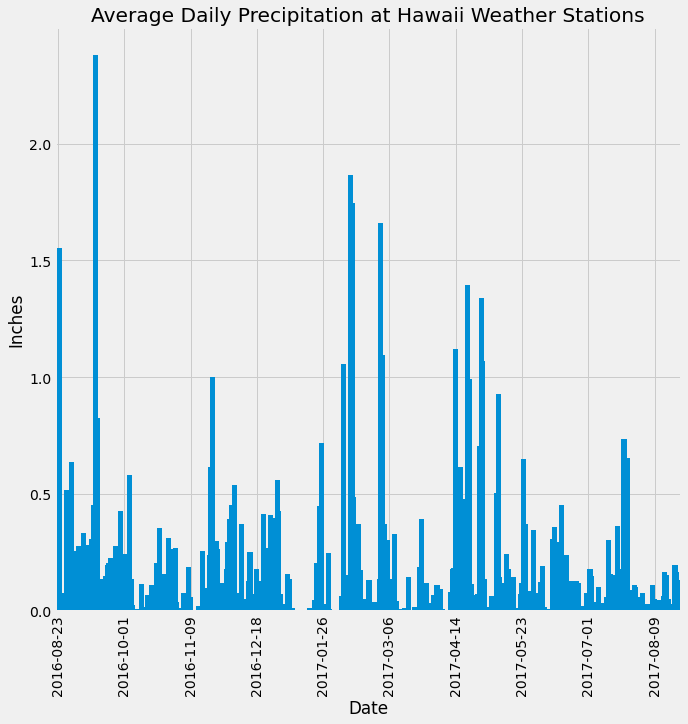

In [48]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(
    kind="bar",
    title="Average Daily Precipitation at Hawaii Weather Stations",
    figsize=(10, 10),
    width=3,
    legend=False,
)
plt.locator_params(axis="x", nbins=9.5)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [49]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [53]:
# Design a query to show how many stations are available in this dataset?
num_station_measurement = len(session.query(Measurement.station).distinct().all())
print(f"Number of stations in Measurement table: {num_station_measurement}")

num_station = len(session.query(Station.station).distinct().all())
print(f"Number of stations in Station table: {num_station}")

Number of stations in Measurement table: 9
Number of stations in Station table: 9


In [69]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_station = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
)
print(
    f"Station {active_station.first()[0]} has the most temp and precipitation reports: {active_station.first()[1]}"
)

Station USC00519281 has the most temp and precipitation reports: 2772
